In [ ]:
from glob import glob
import numpy as np
from scipy.io import loadmat
import rasterio as rio
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')
     

S_sentinel_bands = glob("sundarbans_data/*B?*.tiff")
S_sentinel_bands.sort()

l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

# Data
arr_st = np.stack(l)

# Ground Truth
y_data = loadmat('Sundarbands_gt.mat')['gt']

[scatterd] >WARNING> CPLE_AppDefined in sundarbans_data\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
[scatterd] >WARNING> CPLE_AppDefined in TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
[scatterd] >WARNING> CPLE_AppDefined in sundarbans_data\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
[scatterd] >WARNING> CPLE_AppDefined in TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
[scatterd] >WARNING> CPLE_AppDefined in sundar

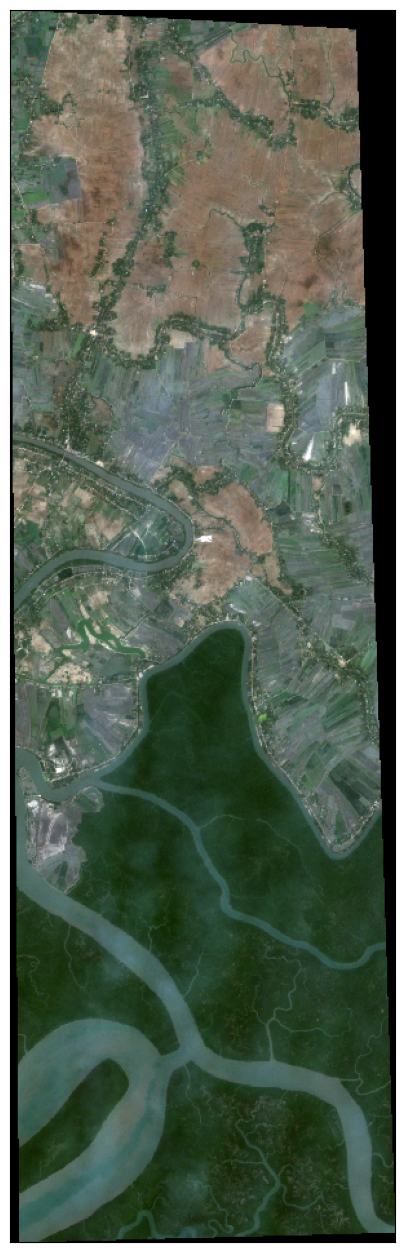

In [8]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.02,
    figsize=(12, 16),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

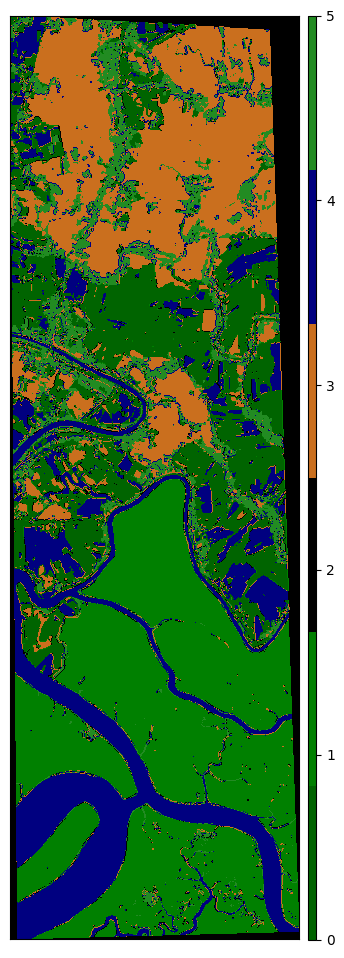

In [9]:
# Visualize Groundtruth

ep.plot_bands(y_data, 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

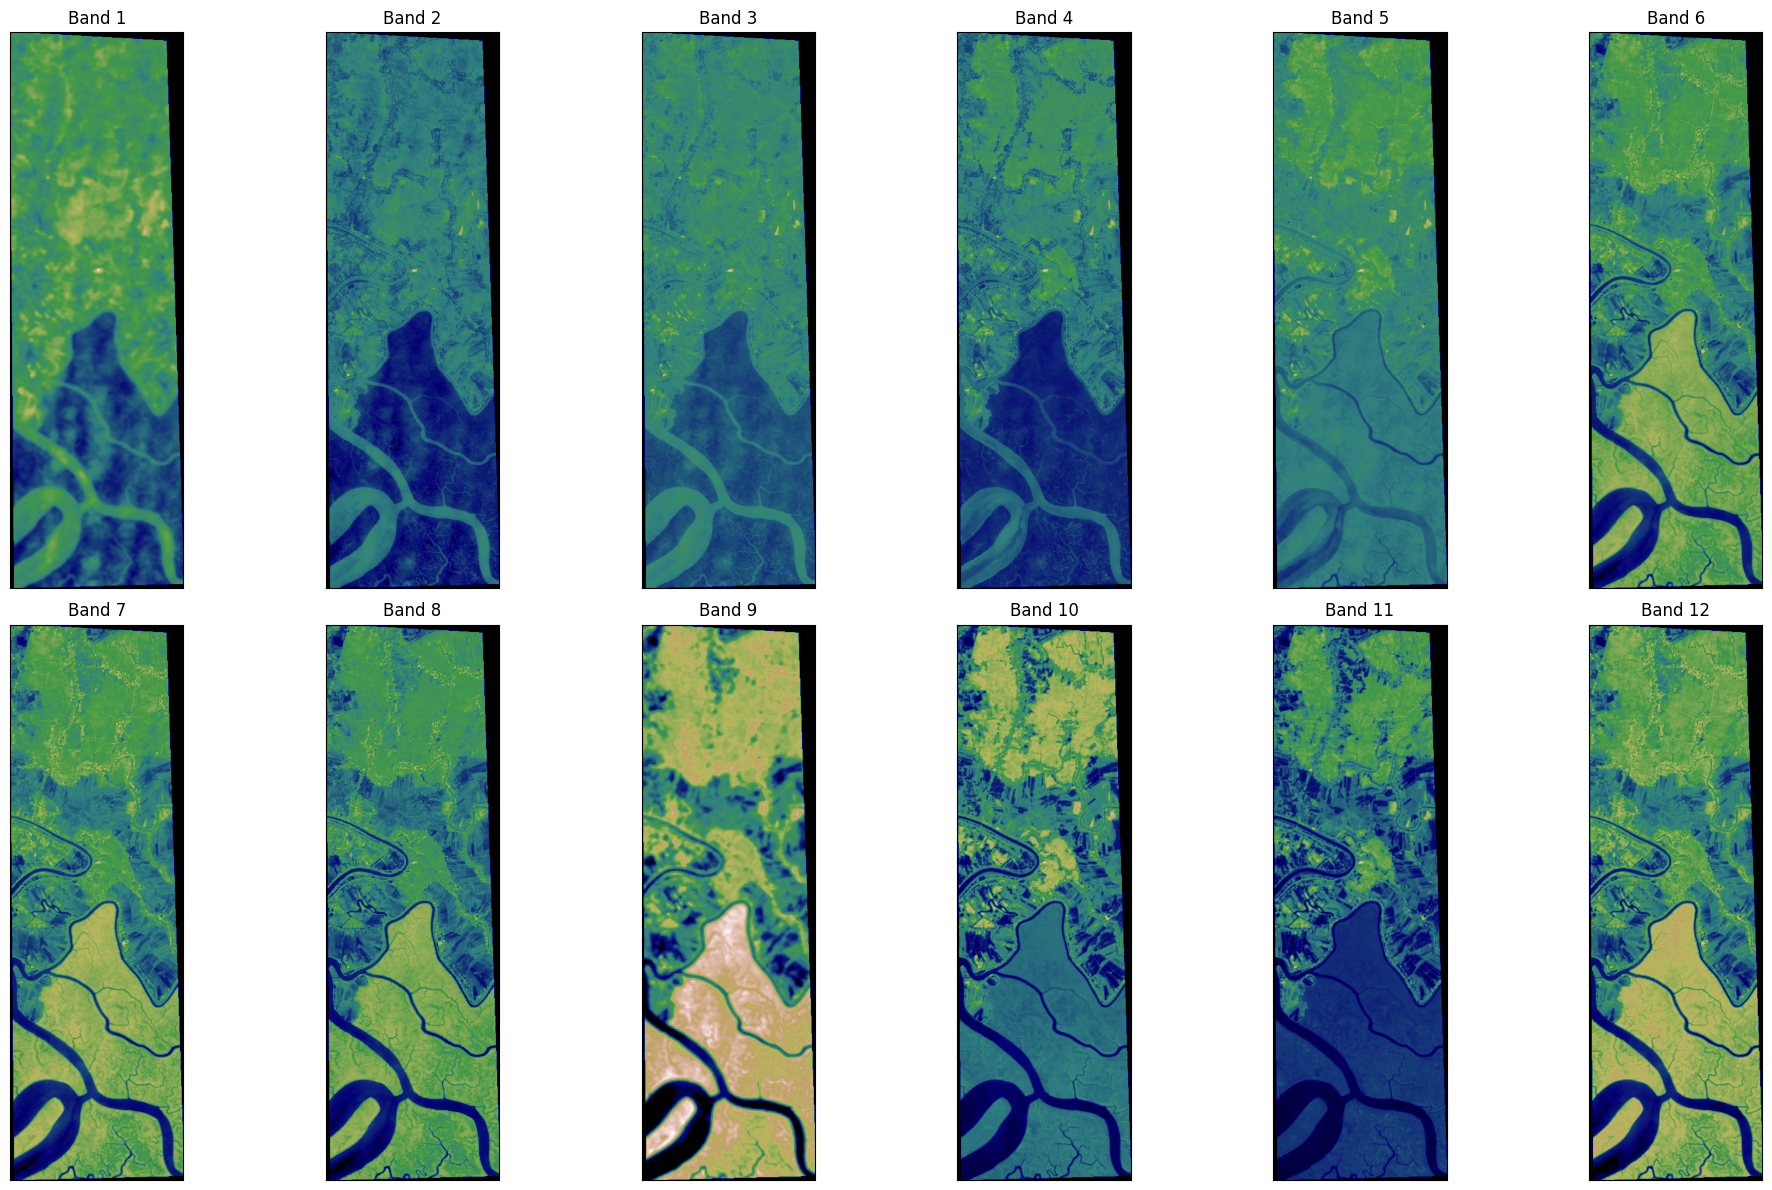

In [10]:
ep.plot_bands(arr_st, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 6, 
              cbar = False)
plt.show()

In [11]:
import pca
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX
def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
def splitTrainTestSet(X, y, testRatio, randomState=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test
## GLOBAL VARIABLES
dataset = 'SB'
test_size = 0.30
windowSize = 15
MODEL_NAME = 'Sundarbans'
path = '/content/drive/MyDrive/Sundarbans/'

X_data = np.moveaxis(arr_st, 0, -1)
y_data = loadmat('Sundarbands_gt.mat')['gt']

# Apply PCA
K = 5
print(f'data before pca:{X_data.shape}')
X,pca = applyPCA(X_data,numComponents=K)

print(f'Data After PCA: {X.shape}')

# Create 3D Patches
X, y = createImageCubes(X, y_data, windowSize=windowSize)
print(f'Patch size: {X.shape}')

# Split train and test
X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, testRatio = test_size)
# X_train=X_train[0:198976]
# y_train=y_train[0:198976]
# X_test=X_test[0:85280]
# y_test=y_test[0:85288]
# X_train=X_train[0:100000]
# y_train=y_train[0:100000]
# X_test=X_test[0:60000]
# y_test=y_test[0:60000]
X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)

# One Hot Encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'Train: {X_train.shape}\nTest: {X_test.shape}\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}')


data before pca:(954, 298, 12)
Data After PCA: (954, 298, 5)
Patch size: (284292, 15, 15, 5)
Train: (199004, 15, 15, 5, 1)
Test: (85288, 15, 15, 5, 1)
Train Labels: (199004, 6)
Test Labels: (85288, 6)


In [40]:
import torch
from dropblock import DropBlock3D

# (bsize, n_feats, depth, height, width)
# x = torch.rand(100, 10, 16, 16, 16)

drop_block3d = DropBlock3D(block_size=2, drop_prob=0.1)


In [41]:
import torch
from dropblock import DropBlock2D

# (bsize, n_feats, height, width)
# x = torch.rand(100, 10, 16, 16)

drop_block2d = DropBlock2D(block_size=3, drop_prob=0.1)


In [42]:
#latest edited
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [43]:
# class BasicBlock(nn.Module):

#   expansion=1 # expansion is 1 as there is no expansion factor is basic block

#   def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):

#     super().__init__()

#     self.conv1 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(2,2,3), padding=1, stride=1, bias=False) # 3x3 Conv Layer
#     self.bn1 = nn.BatchNorm3d(num_features = out_channels)
#     self.relu = nn.ReLU(inplace=True)
#     self.conv2 = nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(2,2,3), padding=1, stride=1, bias=False)
#     self.bn2 = nn.BatchNorm3d(num_features=out_channels)
#     self.downsample = downsample

#   def forward(self, x):

#     identity = x
#     x = self.conv1(x)
#     x = self.bn1(x)
#     x = self.relu(x)
    
#     x = self.conv2(x)
#     x = self.bn2(x)

#     if self.downsample is not None:
#       identity = self.downsample(x)

#     x += identity

#     return (self.relu(x))


In [44]:
# class ResNet(nn.Module):

#   def __init__(self, block, layers, num_classes):

#     super().__init__()

#     self.in_channels = 64

#     # resnet stem
#     self.conv1 = nn.Conv3d(in_channels=3, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
#     self.bn1 = nn.BatchNorm3d(num_features = self.in_channels)
#     self.relu = nn.ReLU(inplace=True)
#     self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2, padding=1)

#     #res-blocks
#     self.layer1 = self._make_layer(block, 64, layers[0])
#     self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#     self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#     self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

#     #classifier block
#     self.adppool = nn.AdaptiveAvgPool2d((2,2))
#     self.classifier = nn.Linear(in_features=512 * block.expansion, out_features = num_classes)


#   def _make_layer(self, block, out_channels, blocks, stride=1):

#     downsample = None


#     if stride!=1 or self.in_channels != out_channels * block.expansion:

#       downsample = nn.Sequential(
#           nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
#           nn.BatchNorm2d(num_features=out_channels * block.expansion)
#     )

#     layers=[]

#     layers.append(block(self.in_channels, out_channels, stride, downsample))

#     self.in_channels = out_channels * block.expansion

#     for i in range(1, blocks):
#       layers.append(block(self.in_channels, out_channels))

#     return nn.Sequential(*layers)



#   def forward(self, x):

#     x = self.conv1(x)
#     x = self.bn1(x)
#     x = self.relu(x)
#     x = self.maxpool(x)
#     x = self.layer1(x)
#     x = self.layer2(x)
#     x = self.layer3(x)
#     x = self.layer4(x)
#     x = self.adppool(x)
#     x = torch.flatten(x, 1)

#     return self.classifier(x)
     

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

def calculate_padding(k1, s1, k2 , s2, k3, s3):
    return ((k1 - s1)//2 , (k2-s2)//2 , (k3-s3)//2)

class ResNet3D(nn.Module):
    def __init__(self, output_units):
        super(ResNet3D, self).__init__()

        # First layer
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=calculate_padding(3,1,3,2,3,2))
        self.conv11 = nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(1,1,3,1,3,1))
        self.norm1 = nn.BatchNorm3d(32)
        
        # Second layer
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(1,1,3,1,3,1))
        self.conv22 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(1,1,3,1,3,1))
        self.norm2 = nn.BatchNorm3d(64)
        
        # Third layer
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 2, 2), stride=(1, 2, 2), padding=calculate_padding(3,1,2,1,2,1))
        self.conv33 = nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=calculate_padding(2,1,3,1,3,1))
        self.norm3 = nn.BatchNorm3d(128)
        
        # Fourth layer
        self.conv4 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(2, 1, 1), stride=(1, 1, 1), padding=calculate_padding(2,1,2,1,2,1))
        # self.conv44 = nn.Conv3d(in_channels=64, out_channels=16, kernel_size=(2, 2, 2), stride=(1, 1, 1), padding=calculate_padding(2, 1,2,1,2,1))
        # self.norm4 = nn.BatchNorm3d(16)
        
        # Fifth layer
        self.conv5 = nn.Conv3d(in_channels=64, out_channels=16, kernel_size=(3, 2, 2), stride=(1, 1, 1), padding=calculate_padding(1,1,1,1,1,1))
        
        # Flatten and dense layer
        self.flatten = nn.Flatten()
        self.final_cnn_dense = nn.Linear(16 *2*2*2, output_units)  # Adjusted based on input dimension reduction

    def forward(self, x):
        # x = x.permute(0, 4, 1, 2, 3)
        # print(x.shape)
        
        x = self.conv1(x)
        residual1=x
        # print(x.shape)
        x = self.conv11(x)
        # print(x.shape)
        x = self.norm1(x)
        # print(x.shape)
        
        # residual1 = self.conv1(x)
        x = x + residual1
        x=drop_block3d(x)
        # print(x.shape)
        x = F.relu(x)
        # print("second strat")
        x = self.conv2(x)
        # print("3rd start")
        # print(x.shape)
        residual2=x
        x=drop_block3d(x)
        x = self.conv22(x)
        # print(x.shape)
        x = self.norm2(x)
        # print(x.shape)
        
        # residual2 = self.conv2(x)
        x = x + residual2
        # print("after add",x.shape)
        x = F.relu(x)
        
        # print("3rd start")
        x = self.conv3(x)
        # print(x.shape)
        residual3=x
        x = self.conv33(x)
        # print(x.shape)
        x = self.norm3(x)
        # print(x.shape)
        # x = F.relu(x)
        # residual3 = self.conv3(x)
        x = x + residual3
        x = F.relu(x)

        # print(x.shape)
        x = self.conv4(x)
        # residual4=x
        # x = self.conv44(x)
        # x = self.norm4(x)
        # x = F.relu(x)
        # residual4 = self.conv4(x)
        # x = x + residual4
        x = F.relu(x)
        # print(x.shape)

        x = self.conv5(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.final_cnn_dense(x)
        return x

# Example usage
output_units = 6  # Example output units, adjust based on y_train.shape[1]

# Initialize model
model = ResNet3D(output_units=output_units)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_train_tensor = X_train_tensor.permute(0, 4, 3, 1, 2)
# X_train_tensor = X_train_tensor.permute(0, 2, 1, 3, 4)
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


ResNet3D(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 0, 0))
  (conv11): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (norm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (conv22): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (norm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(64, 128, kernel_size=(3, 2, 2), stride=(1, 2, 2), padding=(1, 0, 0))
  (conv33): Conv3d(128, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (norm3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(128, 64, kernel_size=(2, 1, 1), stride=(1, 1, 1))
  (conv5): Conv3d(64, 16, kernel_size=(3, 2, 2), stride=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (final_cnn_d

In [52]:
X_train_tensor.shape

torch.Size([199004, 1, 5, 15, 15])

In [53]:

# output_units = y_train.shape[1]
# model = ResNet3D(output_units)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device='cpu'
# model.to(device)


In [54]:
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        # if i == 6217:
        #     print("ab na ho payega bhai")
        #     break

# Save the trained model
# torch.save(model.state_dict(), '3d_cnn_model.pth')


Epoch [1/2], Step [100/6219], Loss: 0.3849
Epoch [1/2], Step [200/6219], Loss: 0.3599
Epoch [1/2], Step [300/6219], Loss: 0.2497
Epoch [1/2], Step [400/6219], Loss: 0.4285
Epoch [1/2], Step [500/6219], Loss: 0.3369
Epoch [1/2], Step [600/6219], Loss: 0.1280
Epoch [1/2], Step [700/6219], Loss: 0.0976
Epoch [1/2], Step [800/6219], Loss: 0.1164
Epoch [1/2], Step [900/6219], Loss: 0.2869
Epoch [1/2], Step [1000/6219], Loss: 0.1858
Epoch [1/2], Step [1100/6219], Loss: 0.0690
Epoch [1/2], Step [1200/6219], Loss: 0.0646
Epoch [1/2], Step [1300/6219], Loss: 0.3116
Epoch [1/2], Step [1400/6219], Loss: 0.2295
Epoch [1/2], Step [1500/6219], Loss: 0.0749
Epoch [1/2], Step [1600/6219], Loss: 0.2782
Epoch [1/2], Step [1700/6219], Loss: 0.4815
Epoch [1/2], Step [1800/6219], Loss: 0.1441
Epoch [1/2], Step [1900/6219], Loss: 0.0783
Epoch [1/2], Step [2000/6219], Loss: 0.0472
Epoch [1/2], Step [2100/6219], Loss: 0.4674
Epoch [1/2], Step [2200/6219], Loss: 0.1033
Epoch [1/2], Step [2300/6219], Loss: 0.10

In [55]:
# X_test=X_test[0:85288]
# y_test=y_test[0:85288]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(train_dataset, batch_size=32)


In [56]:
# Put the model in evaluation mode
model.eval()

# Initialize variables to track accuracy and total number of samples
total_correct = 0
total_samples = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for j, (inputs, labels) in enumerate(test_loader):  # Assuming you have a DataLoader named test_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        labels = torch.argmax(labels, 1)  # Convert one-hot encoded labels to class indices
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        # if (j + 1) % 6200 == 0:
        #     break

accuracy = (total_correct / total_samples) * 100
print(f'Accuracy of the model: {accuracy:.2f}%')


Accuracy of the model: 97.72%
